In [135]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect

from runmainsim import *

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
patients = ['id001_ac', 'id002_cj', 'id014_rb']
patients = ['id014_rb']
for patient in patients:
#     patient='cj'
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 60*samplerate

    ezregion = ['ctx-lh-bankssts']
#     pzregion = ['ctx-lh-cuneus']
    pzregion = []

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    filename = os.path.join(outputdir, patient+'_sim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')

    x0norm=-2.4
    x0ez=-1.5
    x0pz=2.05

    root_dir = os.getcwd()
    project_dir = os.path.join(root_dir, "metadata/"+patient)
    print "Project directory for meta data is : ", project_dir

    confile = os.path.join(project_dir, "connectivity.zip")

    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    try:
        os.rename(sensorsfile, newsensorsfile)
    except:
        print "Already renamed seeg.xyz possibly!"

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
        os.rename(gainmatfile, newgainmatfile)
    except:
        print "Already renamed gain_inv-square.mat possibly!"

    sim, configs = initmodel(confile, newsensorsfile, newgainmatfile, ezregion=ezregion, pzregion=pzregion, x0norm=x0norm, x0ez=x0ez, x0pz=x0pz)

    times, epilepts, seegts = runsim(sim, sim_length)

    # save data now from output and get relevant data
    display(configs)

    ######################## POST PROCESSING #################################
    # post process by cutting off first 5 seconds of simulation
    # for now, don't, since intiial conditions
    times, epits, seegts, zts = postprocts(epilepts, seegts, times)
    
    ezindices, pzindices = getindexofregion(configs.connectivity.region_labels, ezregion, pzregion)
    # get the onset, offset times
    onsettimes = None
    offsettimes = None
    try:
        onsettimes, offsettimes = findonsetoffset(zts[ezindices, :].squeeze())
    except:
        print "Still not working..."

    ######################## SAVING ALL DATA #################################
    regions = configs.connectivity.region_labels
    # Save files
    meta = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': regions,
        'regions_centers': configs.connectivity.centres,
        'seeg_contacts': configs.monitors[1].sensors.labels,
        'seeg_xyz': configs.monitors[1].sensors.locations,
        'ez': regions[ezindices],
        'pz': regions[pzindices],
        'ezindices': ezindices,
        'pzindices': pzindices,
        'onsettimes':onsettimes,
        'offsettimes':offsettimes,
        'patient':patient,
    }

    # save tseries
    np.savez(filename, epits=epits, seegts=seegts, \
             times=times, zts=zts, metadata=meta)
    break

Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id014_rb
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!


Simulator(bound=False, value=None)

/Users/adam2392/Documents/pydata/tvb_forwardsim/id014_rb/id014_rb_sim_nez1_npz0.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[]


<IPython.core.display.Javascript object>


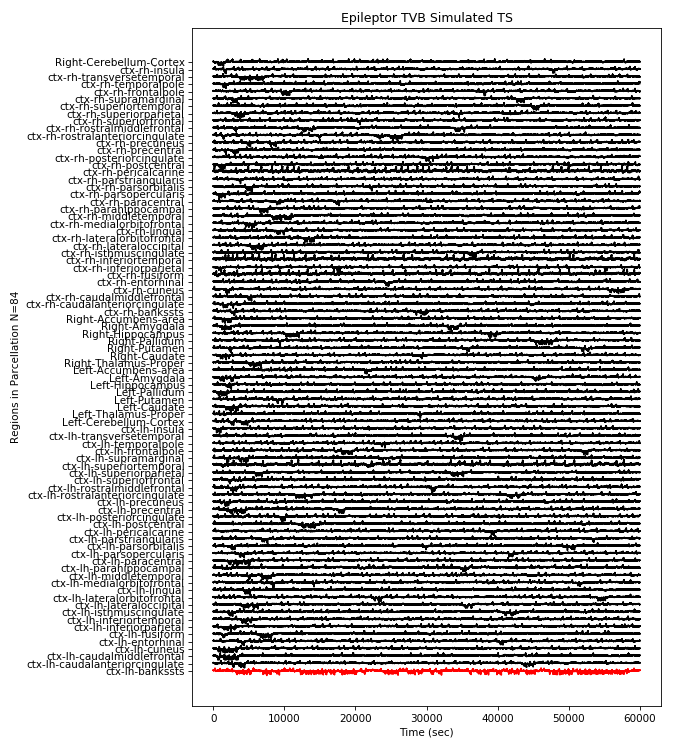

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
(84, 60000)


In [137]:
from visualize import *

data = np.load(filename)

ezindices = []
epits = data['epits']
metadata = data['metadata'].item()
zts = data['zts']
times = data['times']

print filename
print data.keys()
print metadata.keys()
print metadata['pzindices']

regions = metadata['regions']
ezregion = metadata['ez']
pzregion = []

onsettimes = metadata['onsettimes']
offsettimes = metadata['offsettimes']
onsettimes = np.array([tupl for tupl in onsettimes])
offsettimes = np.array([tupl for tupl in offsettimes])
# visualize results and make sure seizure length/look is normal
# plotepileptorts(epits, regions, ezregion)
# initialize figure
epifig = plt.figure(figsize=(9,10))

# get shapes of epits
numregions, numsamps = epits.shape

timewindowbegin = 0
timewindowend = numsamps

regionstoplot = np.array((), dtype='int')
ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
regionstoplot = np.append(regionstoplot, ezindices)
regionstoplot = np.append(regionstoplot, pzindices)

# get random indices not within ez, or pz
numbers = np.arange(0, numregions)
numbers = np.delete(numbers, np.concatenate((ezindices, pzindices), axis=0))
randindices = np.random.choice(numbers, 3)
regionstoplot = np.append(regionstoplot, randindices)

regionstoplot = np.arange(0,len(regions), dtype='int')


print regionstoplot
# Normalize the time series to have nice plots
epirange = (np.max(epits, 1) - np.min(epits, 1))
epits = epits/epirange[:,np.newaxis]
print epits.shape

# get the epi ts to plot and the corresponding time indices
epitoplot = epits[regionstoplot, timewindowbegin:timewindowend]
timestoplot = times[timewindowbegin:timewindowend]

regionlabels = regions[regionstoplot]

# regularization factors for each plot
regf = 0
regt = len(regionstoplot)


    
# plot time series
epilines = plt.plot(timestoplot, epitoplot.T + np.r_[regf:regt], 'k')
ax = plt.gca()

# plot 3 different colors - normal, ez, pz
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = ['red','blue', 'black']
for i,j in enumerate(ax.lines):
    if i in ezindices:
        j.set_color(colors[0])
    elif i in pzindices:
        j.set_color(colors[1])
    else:
        j.set_color(colors[2])

# for idx in range(0, len(onsettimes)):
#     plt.axvline(onsettimes[idx], color='red')
#     plt.axvline(offsettimes[idx], color='red')
    
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Regions in Parcellation N=84')
ax.set_title('Epileptor TVB Simulated TS')
ax.set_yticks(np.r_[regf:regt])
ax.set_yticklabels(regions[regionstoplot])
plt.tight_layout()
plt.show()



# Old Simulation
With Ks=-10
epitt = 0.1

/Users/adam2392/Documents/pydata/tvb_forwardsim/id014_rb/id014_rbtesttest_sim_nez1_npz0.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[]


<IPython.core.display.Javascript object>


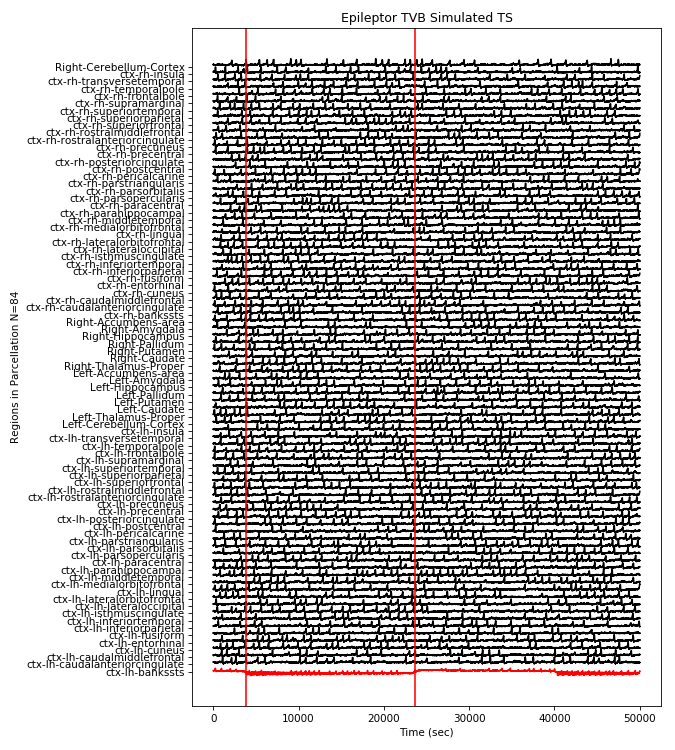

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
(84, 50000)


In [131]:
from visualize import *

data = np.load(filename)

ezindices = []
epits = data['epits']
metadata = data['metadata'].item()
zts = data['zts']
times = data['times']

print filename
print data.keys()
print metadata.keys()
print metadata['pzindices']

regions = metadata['regions']
ezregion = metadata['ez']
pzregion = []

onsettimes = metadata['onsettimes']
offsettimes = metadata['offsettimes']
onsettimes = np.array([tupl for tupl in onsettimes])
offsettimes = np.array([tupl for tupl in offsettimes])
# visualize results and make sure seizure length/look is normal
# plotepileptorts(epits, regions, ezregion)
# initialize figure
epifig = plt.figure(figsize=(9,10))

# get shapes of epits
numregions, numsamps = epits.shape

timewindowbegin = 0
timewindowend = numsamps

regionstoplot = np.array((), dtype='int')
ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
regionstoplot = np.append(regionstoplot, ezindices)
regionstoplot = np.append(regionstoplot, pzindices)

# get random indices not within ez, or pz
numbers = np.arange(0, numregions)
numbers = np.delete(numbers, np.concatenate((ezindices, pzindices), axis=0))
randindices = np.random.choice(numbers, 3)
regionstoplot = np.append(regionstoplot, randindices)

regionstoplot = np.arange(0,len(regions), dtype='int')


print regionstoplot
# Normalize the time series to have nice plots
epirange = (np.max(epits, 1) - np.min(epits, 1))
epits = epits/epirange[:,np.newaxis]
print epits.shape

# get the epi ts to plot and the corresponding time indices
epitoplot = epits[regionstoplot, timewindowbegin:timewindowend]
timestoplot = times[timewindowbegin:timewindowend]

regionlabels = regions[regionstoplot]

# regularization factors for each plot
regf = 0
regt = len(regionstoplot)


    
# plot time series
epilines = plt.plot(timestoplot, epitoplot.T + np.r_[regf:regt], 'k')
ax = plt.gca()

# plot 3 different colors - normal, ez, pz
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = ['red','blue', 'black']
for i,j in enumerate(ax.lines):
    if i in ezindices:
        j.set_color(colors[0])
    elif i in pzindices:
        j.set_color(colors[1])
    else:
        j.set_color(colors[2])

for idx in range(0, len(onsettimes)):
    plt.axvline(onsettimes[idx], color='red')
    plt.axvline(offsettimes[idx], color='red')
    
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Regions in Parcellation N=84')
ax.set_title('Epileptor TVB Simulated TS')
ax.set_yticks(np.r_[regf:regt])
ax.set_yticklabels(regions[regionstoplot])
plt.tight_layout()
plt.show()

In [122]:
print offsettimes
print onsettimes

[ 1981 18538 37439]
[10619 28848 46664]
